<a href="https://www.kaggle.com/code/rubanzasilva/s04e05-fastai?scriptVersionId=176722697" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Regression with a Flood Prediction Dataset

Playground Series - Season 4, Episode 5 where we are tasked with predicting the likelihood of floods in certain areas based off various factors.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flood-prediction-factors/flood.csv
/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
!pip install fastkaggle
!pip install optuna
!pip install optuna_distributed

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.3 MB/s eta 0:00:00


In [3]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

from fastkaggle import setup_comp

import optuna

In [4]:
!ls /kaggle/input/playground-series-s4e5

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


sample_submission.csv  test.csv  train.csv


In [ ]:
#set_seed(42)

In [5]:
path = Path('/kaggle/input/playground-series-s4e5/')
path

Path('/kaggle/input/playground-series-s4e5')

After some experimentation, i noticed adding the original dataset helps the model generalize better and produces better results.

In [6]:
!ls /kaggle/input/flood-prediction-factors

flood.csv


In [7]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')
original_df = pd.read_csv('/kaggle/input/flood-prediction-factors/flood.csv')

In [8]:
train_df.shape,original_df.shape

((1117957, 21), (50000, 21))

In [9]:
train_df = pd.concat([train_df,original_df], axis=0)
train_df.shape

(1167957, 21)

## Dataset Subset

Since the dataset is large and takes a while to train, we can use a subset of the data for quick experimentation

### Using random subset

Using a random subset results in better and faster training

In [22]:
#train_subset = train_df.sample(n=50000,replace=False)
#test_subset = test_df.sample(n=30000,replace=False)

## Using Full Dataset

In [10]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='FloodProbability')

In [11]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [12]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

In [13]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [14]:
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

# Random Forest Baseline

We initially use a random forest as a baseline since it is a really simple model that doesnt break easily with small changes in the hyperparameters etc. 

We can also easily use this for explanability with features such as feature importance.

In [ ]:
%%time
rf = RandomForestRegressor(50, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

# Neural Network Baseline

SuggestedLRs(slide=0.009120108559727669, valley=0.0005754399462603033)

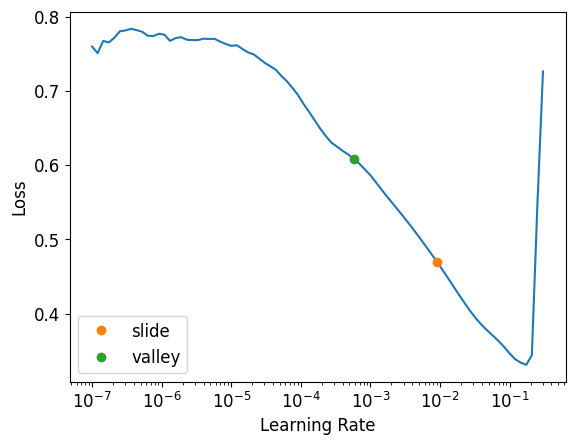

In [18]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [19]:
%%time
learn.fit_one_cycle(15,0.02)

epoch,train_loss,valid_loss,r2_score,time
0,0.000689,0.000507,0.805585,03:13
1,0.000573,0.000446,0.828870,03:13
2,0.000603,0.000492,0.811373,03:30
3,0.000638,0.000525,0.798492,03:47
4,0.000519,0.000590,0.773672,03:51
5,0.000566,0.000464,0.822020,03:51
6,0.000534,0.000712,0.726639,03:57
7,0.000566,0.000467,0.820680,04:15
8,0.000534,0.000411,0.842372,04:22
9,0.000505,0.000436,0.832796,04:07


CPU times: user 1h 51min 4s, sys: 26.6 s, total: 1h 51min 31s
Wall time: 58min


In [20]:
dl = learn.dls.test_dl(test_df)

In [21]:
%%time
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

CPU times: user 4min 49s, sys: 940 ms, total: 4min 49s
Wall time: 2min 27s


In [20]:
!ls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


models


In [ ]:
learn.export('models/fp_model.pkl')

In [ ]:
#learn.load('fp_model.pkl')

In [25]:
r2_score(y_test,nn_preds_x)

0.8600846881172929

In [23]:
r2_score(y_test,nn_preds_x)

0.8610728880238162

In [25]:
target_preds = nn_preds[0]

In [26]:
test_df['FloodProbability'] = target_preds

In [27]:
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

In [28]:
submission = pd.read_csv('submission.csv')
submission.head()

,id,FloodProbability
0,1117957,0.574053
1,1117958,0.456751
2,1117959,0.456521
3,1117960,0.468869
4,1117961,0.469150


In [ ]:
!rm submission.csv

In [ ]:
test_df['FloodProbability'] = target_preds
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

In [29]:
!ls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


catboost_info  models  submission.csv


# Random Forest Baseline

In [30]:
rf = RandomForestRegressor(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

0.6564856488657197

In [ ]:
!ls

# Optimize Params with Optuna

In [27]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse

study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=200)
print(study_catboost.best_params)

[I 2024-05-09 18:47:52,990] A new study created in memory with name: no-name-b9761ae6-e848-4d92-9ad3-a660e61c6c41
[I 2024-05-09 18:48:07,312] Trial 0 finished with value: 0.036140503086392495 and parameters: {'learning_rate': 0.04764874959219648, 'depth': 2, 'random_strength': 2}. Best is trial 0 with value: 0.036140503086392495.
[I 2024-05-09 18:48:23,882] Trial 1 finished with value: 0.02057834510586364 and parameters: {'learning_rate': 0.15801701884613614, 'depth': 4, 'random_strength': 3}. Best is trial 1 with value: 0.02057834510586364.
[I 2024-05-09 18:48:45,813] Trial 2 finished with value: 0.02359453673326331 and parameters: {'learning_rate': 0.05870775853654585, 'depth': 6, 'random_strength': 8}. Best is trial 1 with value: 0.02057834510586364.
[I 2024-05-09 18:49:08,356] Trial 3 finished with value: 0.02634202275151428 and parameters: {'learning_rate': 0.04217409942662681, 'depth': 6, 'random_strength': 8}. Best is trial 1 with value: 0.02057834510586364.
[I 2024-05-09 18:49:

{'learning_rate': 0.2996309085504482, 'depth': 10, 'random_strength': 2}


In [ ]:
def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, lgb_predictions, squared=False)
    return rmse

study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=200)
print(study_lgbm.best_params)

In [ ]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
    return rmse

study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective_xgboost, n_trials=200)
print(study_xgboost.best_params)

# CatBoost Baseline

In [29]:
print(study_catboost.best_params)

{'learning_rate': 0.2996309085504482, 'depth': 10, 'random_strength': 2}


In [30]:
#with optuna params
cat_model = CatBoostRegressor(iterations=1441, depth=10, learning_rate= 0.2996309085504482, random_strength=2)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

0.850540708003807

In [ ]:
#with optuna params
cat_model = CatBoostRegressor(iterations=1441, depth=9, learning_rate= 0.29776650862748444, random_strength=3)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

# Light GBM

In [ ]:
lgb_model = lgb.LGBMRegressor(num_leaves=34, learning_rate=0.1282998099778596, n_estimators=198)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))


r2_score(y_test,lgb_preds_x)

# XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 196, max_depth=5, learning_rate=0.1461774202844157, subsample= 0.6649609199174655)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

# General Ensemble

In [32]:
nn_preds_m = nn_preds_x.squeeze()

In [ ]:
#for r2_Score testing
general_preds = (lgb_preds_x + xgb_preds_x + cat_preds_x + nn_preds_m)/4
general_preds

In [33]:
#for r2_Score testing
general_preds = ( cat_preds_x + nn_preds_m)/2
general_preds

tensor([0.5043, 0.4846, 0.4962,  ..., 0.5670, 0.5888, 0.4040])

In [34]:
r2_score(y_test,general_preds)

0.857749882108003

In [ ]:
r2_score(y_test,general_preds)

In [ ]:
!ls

In [ ]:
general_preds.shape

In [ ]:
#use for submission
general_preds = (cat_preds + nn_preds_y)/2             
general_preds

# Scoring

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!ls

In [ ]:
!rm submission.csv

In [ ]:
def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score

# Create a study
study_lgbm = optuna.create_study(direction='minimize')

# Convert the study to a distributed study
study_lgbm = optuna_distributed.from_study(study_lgbm)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=num_parallel_jobs)

print(study_lgbm.best_params)
